In [21]:
!pip install openmeteo_requests
!pip install requests_cache
!pip install pmdarima
!pip install retry_requests
!pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [22]:
import pickle
import openmeteo_requests
import requests_cache
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from retry_requests import retry


In [23]:

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 10.9645415,
	"longitude": -64.0975447,
	"start_date": "1960-01-01",
	"end_date": "2024-01-01",
	"hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature", "precipitation", "pressure_msl", "surface_pressure", "cloud_cover", "et0_fao_evapotranspiration", "vapour_pressure_deficit", "wind_speed_10m", "soil_temperature_0_to_7cm"],
	"timezone": "America/Sao_Paulo"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(3).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(4).ValuesAsNumpy()
hourly_pressure_msl = hourly.Variables(5).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(6).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(7).ValuesAsNumpy()
hourly_et0_fao_evapotranspiration = hourly.Variables(8).ValuesAsNumpy()
hourly_vapour_pressure_deficit = hourly.Variables(9).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(10).ValuesAsNumpy()
hourly_soil_temperature_0_to_7cm = hourly.Variables(11).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s"),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["Temperatura"] = hourly_temperature_2m
hourly_data["Humedad_rel"] = hourly_relative_humidity_2m
hourly_data["Punto_Dew"] = hourly_dew_point_2m
hourly_data["Temperatura_Ap"] = hourly_apparent_temperature
hourly_data["Precipitacion"] = hourly_precipitation
hourly_data["Presion_mar"] = hourly_pressure_msl
hourly_data["Presion_sup"] = hourly_surface_pressure
hourly_data["Nubosidad"] = hourly_cloud_cover
hourly_data["et0_Evot"] = hourly_et0_fao_evapotranspiration
hourly_data["Deficit_VP"] = hourly_vapour_pressure_deficit
hourly_data["Velocidad_viento"] = hourly_wind_speed_10m
hourly_data["Temp_t_superf"] = hourly_soil_temperature_0_to_7cm

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)


Coordinates 10.931458473205566°E -64.09210205078125°N
Elevation 6.0 m asl
Timezone b'America/Sao_Paulo' b'-03'
Timezone difference to GMT+0 -10800 s
                      date  Temperatura  Humedad_rel  Punto_Dew  \
0      1960-01-01 03:00:00    25.582499    87.398071  23.332499   
1      1960-01-01 04:00:00    25.432499    87.649292  23.232500   
2      1960-01-01 05:00:00    25.332499    87.376038  23.082499   
3      1960-01-01 06:00:00    25.182499    87.893227  23.032499   
4      1960-01-01 07:00:00    24.932499    88.943016  22.982500   
...                    ...          ...          ...        ...   
561043 2024-01-01 22:00:00    28.583000    60.830189  20.282999   
561044 2024-01-01 23:00:00    27.882999    64.942772  20.682999   
561045 2024-01-02 00:00:00    27.733000    65.918678  20.782999   
561046 2024-01-02 01:00:00    27.532999    66.694046  20.782999   
561047 2024-01-02 02:00:00    27.483000    66.683922  20.733000   

        Temperatura_Ap  Precipitacion  Presion

In [24]:
experimental_df=hourly_dataframe.drop(labels=["Temperatura_Ap","Precipitacion","Punto_Dew","Nubosidad","Velocidad_viento","Temp_t_superf"], axis=1)
experimental_df=experimental_df.set_index("date")
experimental_df.tail()

,Temperatura,Humedad_rel,Presion_mar,Presion_sup,et0_Evot,Deficit_VP
date,,,,,,
2024-01-01 22:00:00,28.583000,60.830189,1011.500000,1010.813171,0.166330,1.530595
2024-01-01 23:00:00,27.882999,64.942772,1011.900024,1011.211365,0.110240,1.315266
2024-01-02 00:00:00,27.733000,65.918678,1012.700012,1012.010559,0.099861,1.267515
2024-01-02 01:00:00,27.532999,66.694046,1013.599976,1012.909180,0.084459,1.224309
2024-01-02 02:00:00,27.483000,66.683922,1013.799988,1013.109070,0.081843,1.221115


In [25]:
experimental_df['year'] = [experimental_df.index[i].year for i in range(len(experimental_df))]
experimental_df['month'] = [experimental_df.index[i].month for i in range(len(experimental_df))]
experimental_df['day'] = [experimental_df.index[i].day for i in range(len(experimental_df))]
experimental_df['hour'] = [experimental_df.index[i].hour for i in range(len(experimental_df))]
experimental_df['day_of_week'] = [experimental_df.index[i].dayofweek for i in range(len(experimental_df))]
experimental_df.reset_index(drop=True)
experimental_df.head(20)

,Temperatura,Humedad_rel,Presion_mar,Presion_sup,et0_Evot,Deficit_VP,year,month,day,hour,day_of_week
date,,,,,,,,,,,
1960-01-01 03:00:00,25.582499,87.398071,1012.400024,1011.705688,0.044125,0.412929,1960,1,1,3,4
1960-01-01 04:00:00,25.432499,87.649292,1012.099976,1011.405518,0.040805,0.401119,1960,1,1,4,4
1960-01-01 05:00:00,25.332499,87.376038,1011.799988,1011.105347,0.039934,0.407574,1960,1,1,5,4
1960-01-01 06:00:00,25.182499,87.893227,1011.700012,1011.005188,0.036853,0.387411,1960,1,1,6,4
1960-01-01 07:00:00,24.932499,88.943016,1010.900024,1010.205017,0.031484,0.348597,1960,1,1,7,4
1960-01-01 08:00:00,24.882500,87.867691,1010.799988,1010.105103,0.035970,0.381372,1960,1,1,8,4
1960-01-01 09:00:00,24.832499,87.331802,1011.299988,1010.604492,0.038005,0.397039,1960,1,1,9,4
1960-01-01 10:00:00,24.832499,86.803017,1011.299988,1010.604492,0.039341,0.413616,1960,1,1,10,4
1960-01-01 11:00:00,24.882500,86.281769,1012.500000,1011.803894,0.060999,0.431238,1960,1,1,11,4


In [46]:
lagged_features_df = pd.DataFrame()
lagged_feature = pd.DataFrame()
lagged_feature_names = []
columns=experimental_df.drop(labels=["year","month","day","hour","day_of_week"], axis=1).columns
print(columns)
lag_steps=[7, 30, 365] #In days
for y in lag_steps:
  lag_number=y*24
  for i in columns:
    lagged_feature_name = "retardado_"+str(y)+"_"+str(i)
    lagged_feature_names.append(lagged_feature_name)
    lagged_feature[lagged_feature_name] = experimental_df[i].shift(lag_number)
    lagged_features_df=pd.concat([lagged_features_df, lagged_feature]).dropna()


cualidades_exogenas=(lagged_feature_names + ["year","month","day","day_of_week","hour", 'Humedad_rel', 'Punto_Dew', 'Precipitacion', 'et0_Evot',
       'Deficit_VP'])
lagged_features_df.head(20)
#print(cualidades_exogenas)

Index(['Temperatura', 'Humedad_rel', 'Presion_mar', 'Presion_sup', 'et0_Evot',
       'Deficit_VP'],
      dtype='object')


,retardado_7_Temperatura,retardado_7_Humedad_rel,retardado_7_Presion_mar,retardado_7_Presion_sup,retardado_7_et0_Evot,retardado_7_Deficit_VP,retardado_30_Temperatura,retardado_30_Humedad_rel,retardado_30_Presion_mar,retardado_30_Presion_sup,retardado_30_et0_Evot,retardado_30_Deficit_VP,retardado_365_Temperatura,retardado_365_Humedad_rel,retardado_365_Presion_mar,retardado_365_Presion_sup,retardado_365_et0_Evot,retardado_365_Deficit_VP
date,,,,,,,,,,,,,,,,,,
1960-12-31 03:00:00,24.832499,82.168571,1015.900024,1015.201355,0.063934,0.558916,26.382500,83.608162,1009.900024,1009.209229,0.058346,0.563104,25.582499,87.398071,1012.400024,1011.705688,0.044125,0.412929
1960-12-31 04:00:00,24.532499,83.399551,1015.700012,1015.000916,0.057514,0.511105,26.232500,83.844246,1010.099976,1009.408813,0.053853,0.550115,25.432499,87.649292,1012.099976,1011.405518,0.040805,0.401119
1960-12-31 05:00:00,24.282499,85.437782,1015.299988,1014.600403,0.050028,0.441694,26.032499,84.330475,1009.400024,1008.708618,0.048444,0.527305,25.332499,87.376038,1011.799988,1011.105347,0.039934,0.407574
1960-12-31 06:00:00,24.132500,86.473740,1014.799988,1014.100525,0.043056,0.406602,25.832499,84.820663,1008.900024,1008.208679,0.045948,0.504812,25.182499,87.893227,1011.700012,1011.005188,0.036853,0.387411
1960-12-31 07:00:00,23.782499,88.581787,1014.200012,1013.500244,0.032455,0.336102,25.832499,86.111771,1008.700012,1008.008850,0.044298,0.461862,24.932499,88.943016,1010.900024,1010.205017,0.031484,0.348597
1960-12-31 08:00:00,23.882500,86.980728,1014.599976,1013.899902,0.039200,0.385545,25.732500,86.885544,1008.500000,1007.808594,0.044077,0.433556,24.882500,87.867691,1010.799988,1010.105103,0.035970,0.381372
1960-12-31 09:00:00,23.732500,87.501083,1014.299988,1013.599915,0.038857,0.366818,25.682499,86.880981,1008.799988,1008.108398,0.045126,0.432427,24.832499,87.331802,1011.299988,1010.604492,0.038005,0.397039
1960-12-31 10:00:00,23.732500,87.233696,1014.900024,1014.199524,0.042031,0.374667,25.632500,87.139084,1009.400024,1008.707764,0.040588,0.422666,24.832499,86.803017,1011.299988,1010.604492,0.039341,0.413616
1960-12-31 11:00:00,23.932499,86.190651,1015.700012,1014.999573,0.064604,0.410174,25.682499,86.880981,1009.099976,1008.408142,0.056646,0.432427,24.882500,86.281769,1012.500000,1011.803894,0.060999,0.431238


In [27]:
model_df=experimental_df.join(lagged_features_df).dropna()
model_df.index=pd.DatetimeIndex(model_df.index, freq=model_df.index.inferred_freq)
model_df.tail()

,Temperatura,Humedad_rel,Presion_mar,Presion_sup,et0_Evot,Deficit_VP,year,month,day,hour,...,retardado_30_Presion_mar,retardado_30_Presion_sup,retardado_30_et0_Evot,retardado_30_Deficit_VP,retardado_365_Temperatura,retardado_365_Humedad_rel,retardado_365_Presion_mar,retardado_365_Presion_sup,retardado_365_et0_Evot,retardado_365_Deficit_VP
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01 22:00:00,28.583000,60.830189,1011.500000,1010.813171,0.166330,1.530595,2024,1,1,22,...,1011.200012,1010.513367,0.157331,1.371822,27.032999,68.466713,1011.500000,1010.809692,0.145719,1.125739
2024-01-01 23:00:00,27.882999,64.942772,1011.900024,1011.211365,0.110240,1.315266,2024,1,1,23,...,1011.400024,1010.712402,0.114848,1.216026,26.083000,76.286781,1012.200012,1011.507019,0.071226,0.800496
2024-01-02 00:00:00,27.733000,65.918678,1012.700012,1012.010559,0.099861,1.267515,2024,1,2,0,...,1012.000000,1011.311035,0.103270,1.094078,26.333000,74.938530,1013.200012,1012.506714,0.068762,0.858578
2024-01-02 01:00:00,27.532999,66.694046,1013.599976,1012.909180,0.084459,1.224309,2024,1,2,1,...,1012.000000,1011.311279,0.092128,1.102625,26.083000,76.754669,1014.099976,1013.405701,0.064118,0.784693
2024-01-02 02:00:00,27.483000,66.683922,1013.799988,1013.109070,0.081843,1.221115,2024,1,2,2,...,1012.299988,1011.610779,0.088114,1.050719,25.733000,78.842461,1014.599976,1013.904358,0.056191,0.699586


In [28]:
model_df.head()

,Temperatura,Humedad_rel,Presion_mar,Presion_sup,et0_Evot,Deficit_VP,year,month,day,hour,...,retardado_30_Presion_mar,retardado_30_Presion_sup,retardado_30_et0_Evot,retardado_30_Deficit_VP,retardado_365_Temperatura,retardado_365_Humedad_rel,retardado_365_Presion_mar,retardado_365_Presion_sup,retardado_365_et0_Evot,retardado_365_Deficit_VP
date,,,,,,,,,,,,,,,,,,,,,
1960-12-31 03:00:00,25.332499,80.984573,1011.200012,1010.505798,0.068116,0.614003,1960,12,31,3,...,1009.900024,1009.209229,0.058346,0.563104,25.582499,87.398071,1012.400024,1011.705688,0.044125,0.412929
1960-12-31 04:00:00,25.282499,81.972702,1011.000000,1010.305908,0.062004,0.580363,1960,12,31,4,...,1010.099976,1009.408813,0.053853,0.550115,25.432499,87.649292,1012.099976,1011.405518,0.040805,0.401119
1960-12-31 05:00:00,25.232500,82.719727,1010.900024,1010.205750,0.057649,0.554659,1960,12,31,5,...,1009.400024,1008.708618,0.048444,0.527305,25.332499,87.376038,1011.799988,1011.105347,0.039934,0.407574
1960-12-31 06:00:00,25.232500,82.719727,1010.299988,1009.606140,0.056459,0.554659,1960,12,31,6,...,1008.900024,1008.208679,0.045948,0.504812,25.182499,87.893227,1011.700012,1011.005188,0.036853,0.387411
1960-12-31 07:00:00,25.182499,83.473282,1010.400024,1009.706116,0.053528,0.528892,1960,12,31,7,...,1008.700012,1008.008850,0.044298,0.461862,24.932499,88.943016,1010.900024,1010.205017,0.031484,0.348597


In [29]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(model_df)

# Define sequence length and features
sequence_length = 24  # Number of time steps in each sequence
num_features = len(model_df.columns)

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_data) - sequence_length):
    seq = scaled_data[i:i+sequence_length]
    label = scaled_data[i+sequence_length][0]  # 'temp' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
rain_train_x, rain_test_x = sequences[:train_size], sequences[train_size:]
rain_train_y, rain_test_y = labels[:train_size], labels[train_size:]

print("Model_df",model_df.shape)

print("Train X shape:", rain_train_x.shape)
print("Train Y shape:", rain_train_y.shape)

print("Test X shape:", rain_test_x.shape)
print("Test Y shape:", rain_test_y.shape)

Model_df (552288, 29)
Train X shape: (441811, 24, 29)
Train Y shape: (441811,)
Test X shape: (110453, 24, 29)
Test Y shape: (110453,)


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Create the LSTM model
rain_model = Sequential()

# Add LSTM layers with dropout
rain_model.add(LSTM(units=128, input_shape=(rain_train_x.shape[1], rain_train_x.shape[2]), return_sequences=True))
rain_model.add(Dropout(0.2))

rain_model.add(LSTM(units=64, return_sequences=True))
rain_model.add(Dropout(0.2))

rain_model.add(LSTM(units=32, return_sequences=False))
rain_model.add(Dropout(0.2))

# Add a dense output layer
rain_model.add(Dense(units=1))

# Compile the model
rain_model.compile(optimizer='adam', loss='mean_squared_error')

In [31]:
rain_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 24, 128)           80896     
                                                                 
 dropout_3 (Dropout)         (None, 24, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 24, 64)            49408     
                                                                 
 dropout_4 (Dropout)         (None, 24, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [32]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=False)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/dl/Modelo_Temperatura/best_model_weights.h5', monitor='val_loss')

# Train the model
rain_history = rain_model.fit(
    rain_train_x, rain_train_y,
    epochs=110,
    batch_size=64,
    validation_split=0.2,  # Use part of the training data as validation
    callbacks=[early_stopping]
)

Epoch 1/110
5523/5523 [==============================] - 248s 44ms/step - loss: 9.0932e-04 - val_loss: 1.7212e-04
Epoch 2/110
5523/5523 [==============================] - 208s 38ms/step - loss: 1.9393e-04 - val_loss: 8.9977e-05
Epoch 3/110
5523/5523 [==============================] - 202s 37ms/step - loss: 1.6210e-04 - val_loss: 1.4259e-04
Epoch 4/110
5523/5523 [==============================] - 192s 35ms/step - loss: 1.5121e-04 - val_loss: 1.1684e-04
Epoch 5/110
5523/5523 [==============================] - 226s 41ms/step - loss: 1.4735e-04 - val_loss: 1.2315e-04
Epoch 6/110
5523/5523 [==============================] - 230s 42ms/step - loss: 1.4269e-04 - val_loss: 1.2994e-04
Epoch 7/110
5523/5523 [==============================] - 239s 43ms/step - loss: 1.4030e-04 - val_loss: 9.5506e-05
Epoch 8/110
5523/5523 [==============================] - 214s 39ms/step - loss: 1.3637e-04 - val_loss: 8.4449e-05
Epoch 9/110
5523/5523 [==============================] - 211s 38ms/step - loss: 1.3664e-

In [33]:
model_pkl_file = "modelo_temperatura.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(rain_model, file)

In [34]:
model_pkl_file = "modelo_temperatura.pkl"

with open(model_pkl_file, 'rb') as file:  
    rain_model = pickle.load(file)

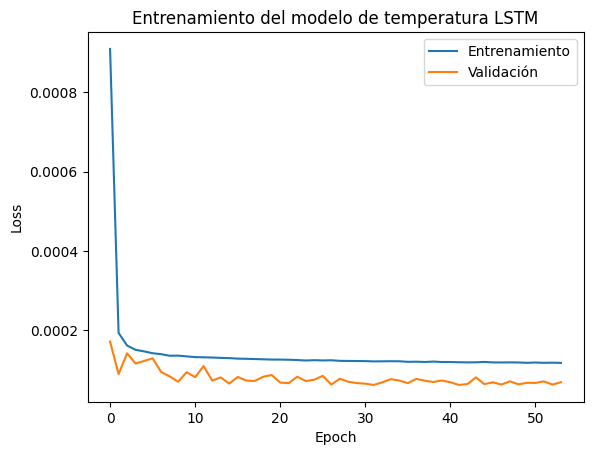

In [35]:
plt.plot(rain_history.history['loss'])
plt.plot(rain_history.history['val_loss'])
plt.title('Entrenamiento del modelo de temperatura LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.show()

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming you have trained the model and have the 'best_model' object
# Also, 'test_x' and 'test_y' should be available
print(" ---------- Cáclulo de métricas de rendimiento ---------- ")
# Predict temperatures using the trained model
predictions = rain_model.predict(rain_test_x)

# Calculate evaluation metrics
mae = mean_absolute_error(rain_test_y, predictions)
mse = mean_squared_error(rain_test_y, predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

 ---------- Cáclulo de métricas de rendimiento ---------- 
3452/3452 [==============================] - 32s 9ms/step
Mean Absolute Error (MAE): 0.01914467936979022
Mean Squared Error (MSE): 0.0010403882243283737
Root Mean Squared Error (RMSE): 0.032255049594263126


In [37]:
future_hours=90*24
row_count=len(model_df.columns)
# y_true values
test_y_copies = np.repeat(rain_test_y.reshape(-1, 1), rain_test_x.shape[-1], axis=-1)
true_temp = scaler.inverse_transform(test_y_copies)[:,0]

# predicted values
prediction = rain_model.predict(rain_test_x)
prediction_copies = np.repeat(prediction, row_count, axis=-1)
predicted_temp = scaler.inverse_transform(prediction_copies)[:,0]

# predicted future values
prediction = rain_model.predict(rain_test_x[-future_hours:])
prediction_copies = np.repeat(prediction, row_count, axis=-1)
predicted_future_temp = scaler.inverse_transform(prediction_copies)[:,0]

#save as csv
#predicted_temp.to_csv("Predicion_temperatura")
#model_df.to_csv("Model_df")

68/68 [==============================] - 1s 9ms/step


In [38]:
predict_period_dates = pd.date_range(list(model_df.index)[-1], periods=future_hours, freq="h")
print(predict_period_dates)
df_forecast=pd.DataFrame({"date":predict_period_dates,"Temperatura":predicted_future_temp})
df_forecast["date"]=pd.to_datetime(df_forecast["date"])
df_forecast=df_forecast.set_index("date", drop=True)

DatetimeIndex(['2024-01-02 02:00:00', '2024-01-02 03:00:00',
               '2024-01-02 04:00:00', '2024-01-02 05:00:00',
               '2024-01-02 06:00:00', '2024-01-02 07:00:00',
               '2024-01-02 08:00:00', '2024-01-02 09:00:00',
               '2024-01-02 10:00:00', '2024-01-02 11:00:00',
               ...
               '2024-03-31 16:00:00', '2024-03-31 17:00:00',
               '2024-03-31 18:00:00', '2024-03-31 19:00:00',
               '2024-03-31 20:00:00', '2024-03-31 21:00:00',
               '2024-03-31 22:00:00', '2024-03-31 23:00:00',
               '2024-04-01 00:00:00', '2024-04-01 01:00:00'],
              dtype='datetime64[ns]', length=2160, freq='h')


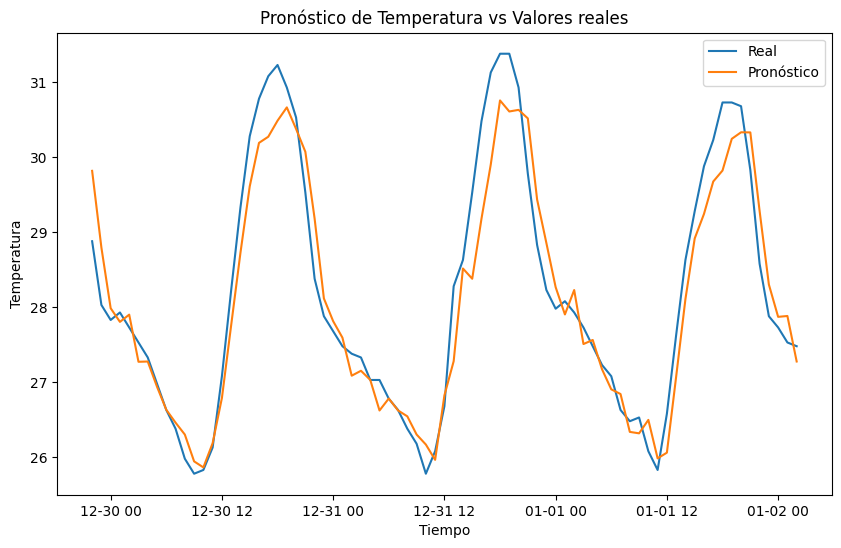

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(model_df["Temperatura"].index[-77:], true_temp[-77:], label='Real')
plt.plot(model_df["Temperatura"].index[-77:], predicted_temp[-77:], label='Pronóstico')
plt.title('Pronóstico de Temperatura vs Valores reales')
plt.xlabel('Tiempo')
plt.ylabel('Temperatura')
plt.legend()
plt.show()

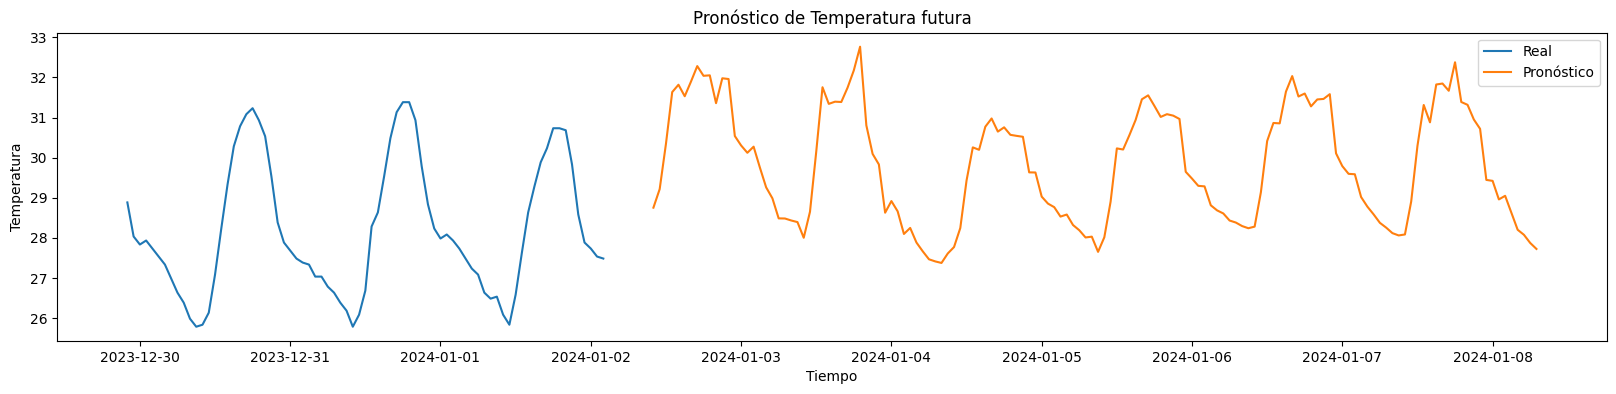

In [53]:
plt.figure(figsize=(20, 4))
plt.plot(model_df["Temperatura"][-77:], label='Real')
plt.plot(df_forecast[8:150], label='Pronóstico')
plt.title('Pronóstico de Temperatura futura')
plt.xlabel('Tiempo')
plt.ylabel('Temperatura')
plt.legend()
plt.show()